In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Define the paths to your data
train_data_dir = '/content/drive/MyDrive/bangla_banknote_v2/Train'
test_data_dir = '/content/drive/MyDrive/bangla_banknote_v2/Validation'

# Define the image dimensions
img_height, img_width = 224, 224

# Define the batch size
batch_size = 32

# Create an ImageDataGenerator for training data with additional augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.4,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.5, 1.5],
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Create an ImageDataGenerator for testing data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for loading images from directories
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the EfficientNetB3 base model (pre-trained on ImageNet)
base_model = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

# Unfreeze the last few layers of the EfficientNetB3 base model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Adjust the top layers of your model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,  # Reduced number of epochs to prevent overfitting
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

Found 1637 images belonging to 9 classes.
Found 540 images belonging to 9 classes.
Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 2.1388 - accuracy: 0.1944

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 569s 10s/step - loss: 2.1388 - accuracy: 0.1944 - val_loss: 2.1985 - val_accuracy: 0.1172 - lr: 1.0000e-04
Epoch 2/50
51/51 [==============================] - 42s 823ms/step - loss: 1.6610 - accuracy: 0.4642 - val_loss: 2.1978 - val_accuracy: 0.1172 - lr: 1.0000e-04
Epoch 3/50
51/51 [==============================] - 42s 818ms/step - loss: 0.9725 - accuracy: 0.6972 - val_loss: 2.2211 - val_accuracy: 0.1113 - lr: 1.0000e-04
Epoch 4/50
51/51 [==============================] - 43s 837ms/step - loss: 0.5349 - accuracy: 0.8330 - val_loss: 2.2335 - val_accuracy: 0.1328 - lr: 1.0000e-04
Epoch 5/50
51/51 [==============================] - 42s 819ms/step - loss: 0.2962 - accuracy: 0.9159 - val_loss: 2.2886 - val_accuracy: 0.1270 - lr: 1.0000e-04
Epoch 6/50
51/51 [==============================] - 40s 787ms/step - loss: 0.1985 - accuracy: 0.9383 - val_loss: 2.2679 - val_accuracy: 0.1387 - lr: 1.0000e-04
Epoch 7/50
51/51 [==============================] - 

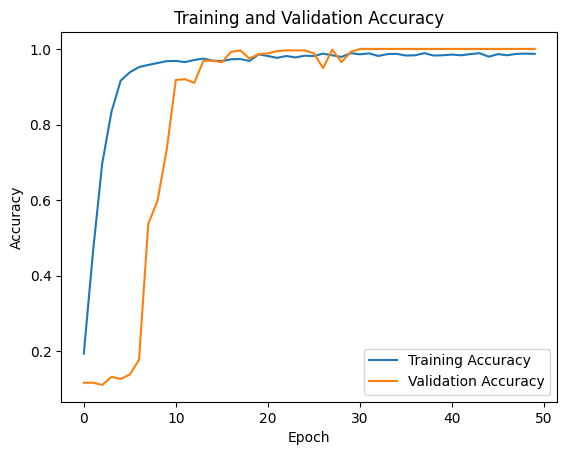

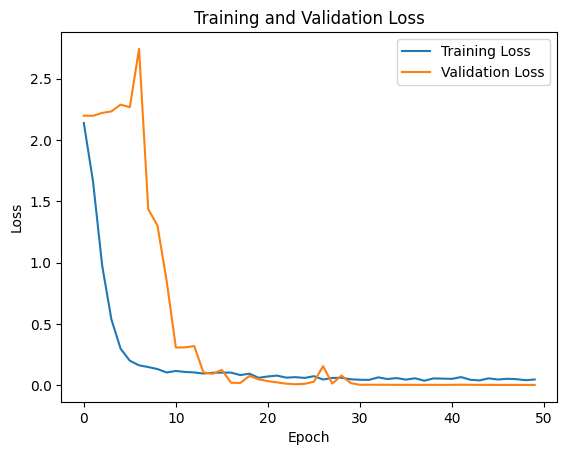

In [4]:
import matplotlib.pyplot as plt


# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

17/17 [==============================] - 11s 316ms/step


<Figure size 1000x800 with 0 Axes>

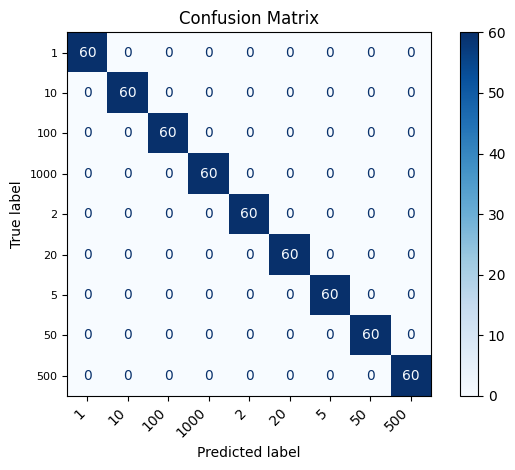

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict classes for the test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
true_labels = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred_classes)

# Plot confusion matrix
classes = list(test_generator.class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Adjust figure size and rotate y-axis labels
plt.figure(figsize=(10, 8))  # Adjust figure size
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.yticks(fontsize=8)
plt.tight_layout()  # Adjust layout
plt.show()


In [6]:
from sklearn.metrics import f1_score

# Compute F1 score for each class
f1_per_class = f1_score(true_labels, y_pred_classes, average=None)

# Print F1 score for each class
for i, f1 in enumerate(f1_per_class):
    print(f"F1 score for class {i}: {f1}")

F1 score for class 0: 1.0
F1 score for class 1: 1.0
F1 score for class 2: 1.0
F1 score for class 3: 1.0
F1 score for class 4: 1.0
F1 score for class 5: 1.0
F1 score for class 6: 1.0
F1 score for class 7: 1.0
F1 score for class 8: 1.0


In [7]:
from sklearn.metrics import precision_score

# Compute precision value for each class
precision_per_class = precision_score(true_labels, y_pred_classes, average=None)

# Print precision value for each class
for i, precision in enumerate(precision_per_class):
    print(f"Precision for class {i}: {precision}")

Precision for class 0: 1.0
Precision for class 1: 1.0
Precision for class 2: 1.0
Precision for class 3: 1.0
Precision for class 4: 1.0
Precision for class 5: 1.0
Precision for class 6: 1.0
Precision for class 7: 1.0
Precision for class 8: 1.0


In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred_classes)

# Compute recall for each class
recall = np.diag(cm) / np.sum(cm, axis=1)

# Print recall for each class
for i, class_name in enumerate(classes):
    print(f'Recall for {class_name}: {recall[i]}')

Recall for 1: 1.0
Recall for 10: 1.0
Recall for 100: 1.0
Recall for 1000: 1.0
Recall for 2: 1.0
Recall for 20: 1.0
Recall for 5: 1.0
Recall for 50: 1.0
Recall for 500: 1.0
